# DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL MODEL - DCGAN - for grayscale hand written digits

### Librerias

In [2]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint

import tensorflow as tf

from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot

### Carga de Datos

In [3]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print("Train", trainX.shape, trainy.shape)
print("Test", testX.shape, testy.shape)

Using TensorFlow backend.


11493376/11490434 [==============================] - 24s 2us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


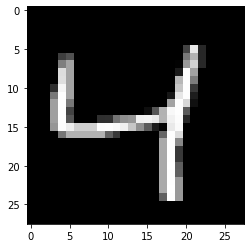

In [5]:
pyplot.imshow(trainX[2], cmap="gray")  #un ejemplo en escala de grises

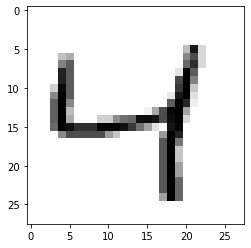

In [8]:
pyplot.imshow(trainX[2], cmap="gray_r")  #colores inversos escala de grises

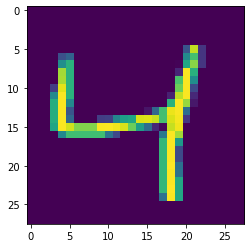

In [9]:
pyplot.imshow(trainX[2])  #a color

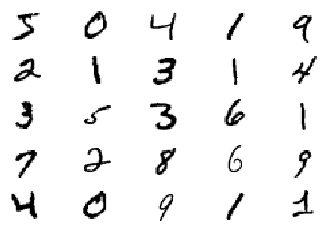

In [10]:
#25 ejemplos de digitos

for i in range(25):
    # define subplot
    pyplot.subplot(5, 5, 1 + i)
    # turn off axis
    pyplot.axis("off")
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap="gray_r")
pyplot.show()

### Definición del modelo discriminador

In [11]:
def define_discriminator(in_shape=(28,28,1)):
    #Tamaño imange 28x28 en 1 canal.
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding="same", input_shape=in_shape))  #64 features, filter 3x3
    model.add(LeakyReLU(alpha=0.2)) #0.2 pendiente
    model.add(Dropout(0.5)) #en tensorflow 2 el numero es lo que se conserva
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    #salida binaria del discriminador: real vs fake
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [12]:
modelo_d = define_discriminator()
modelo_d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

### Definición del modelo generador

In [13]:
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image: tamaño de la imagen despues del dimensión embedding = 49 puntos
    #se quiere ampliar a 28X28 => se amplia con escalimiento (duplicando), por eso se elige 7x7
    #para compensar la baja resolución de inicio, se inicia con 128 nodos de profundidad
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")) # se duplica el ancho y alto
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))  #se duplica al ancho y alto
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation="sigmoid", padding="same"))
    return model

In [16]:
modelo_g = define_generator(100)  #se inicia con un espacio de dimensión 100 arbitrario
modelo_g.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 128)      

### Definición del GAN generador + Discriminador

In [17]:
def define_gan(g_model, d_model):
    # inputs: modelos generador y modelo discriminador
    d_model.trainable = False  #Al iniciol el modelo discirminador no se entrena => se entrena el generador
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

### Preparación de Datos

In [18]:
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()  #solo se cargan los datos de entrenamiento
    X = expand_dims(trainX, axis=-1) #se agrega 1 channel necsario para keras (imágenes) 
    X = X.astype("float32") # se convierten los datos a float
    X = X / 255.0  # se reescala de [0,255] to [0,1]
    return X

### Generación de muestras de imágenes reales y fakes

In [26]:
# muestras reales
def generate_real_samples(dataset, n_samples):
    # dataset: universo de datos reales
    # muestras a generar
    ix = randint(0, dataset.shape[0], n_samples) #generación de un array de numeros  n muestras
    X = dataset[ix]  #con los índices aleatorios se realiza un slice 
    y = ones((n_samples, 1)) # etiqueda de 1 = reales
    return X, y


# genración de puntos en el espacio latente aleatorio
def generate_latent_points(latent_dim, n_samples):
    #latent_dim: tamaño arbitrario de la dimensión latent
    # n_samples: tamaño muestra igual a la del generador - batch of inputs
    x_input = randn(latent_dim * n_samples)   
    x_input = x_input.reshape(n_samples, latent_dim)  # reshape into a batch of inputs for the network
    return x_input


# se generan los datos fake usando el generador y los datos del espacio latente. etiquetas de fake=0
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

### Funciones auxiliares

In [27]:
# guardar las imagenes generadas (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):  #grid imagenes 10x10
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis("off")
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap="gray_r")
        # save plot to file
        filename = "generated_plot_e%03d.png" % (epoch+1)
        pyplot.savefig(filename)
        pyplot.close()
    
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = "generator_model_%03d.h5" % (epoch + 1)
    g_model.save(filename)

### Entrenamiento del generador y discriminador

In [28]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=4, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected ✬real✬ samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate ✬fake✬ examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print(">%d, %d/%d, d=%.3f, g=%.3f" % (i+1, j+1, bat_per_epo, d_loss, g_loss))
            # evaluate the model performance, sometimes
        if (i+1) % 1 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [29]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/234, d=0.698, g=0.687
>1, 2/234, d=0.690, g=0.711
>1, 3/234, d=0.686, g=0.725
>1, 4/234, d=0.673, g=0.747
>1, 5/234, d=0.668, g=0.769
>1, 6/234, d=0.655, g=0.779
>1, 7/234, d=0.649, g=0.795
>1, 8/234, d=0.643, g=0.811
>1, 9/234, d=0.644, g=0.830
>1, 10/234, d=0.640, g=0.825
>1, 11/234, d=0.632, g=0.828
>1, 12/234, d=0.639, g=0.819
>1, 13/234, d=0.636, g=0.801
>1, 14/234, d=0.641, g=0.778
>1, 15/234, d=0.645, g=0.760
>1, 16/234, d=0.646, g=0.741
>1, 17/234, d=0.645, g=0.727
>1, 18/234, d=0.637, g=0.717
>1, 19/234, d=0.635, g=0.710
>1, 20/234, d=0.634, g=0.705
>1, 21/234, d=0.625, g=0.702
>1, 22/234, d=0.615, g=0.700
>1, 23/234, d=0.609, g=0.700
>1, 24/234, d=0.595, g=0.700
>1, 25/234, d=0.591, g=0.700
>1, 26/234, d=0.581, g=0.701
>1, 27/234, d=0.568, g=0.702
>1, 28/234, d=0.561, g=0.703
>1, 29/234, d=0.546, g=0.703
>1, 30/234, d=0.536, g=0.704
>1, 31/234, d=0.525, g=0.705
>1, 32/234, d=0.516, g=0.706
>1, 33/234, d=0.507, g=0.707
>1, 34/234, d=0.498, g=0.708
>1, 35/234, d=0.484, g=

### Uso del Modelo Generador

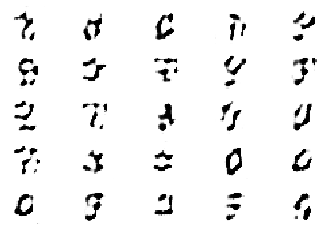

In [33]:
# example of loading the generator model and generating images
from tensorflow.keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis("off")
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap="gray_r")
    pyplot.show()


# load model
model = load_model("generator_model_004.h5")
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

### Uso del generador para un solo dígito

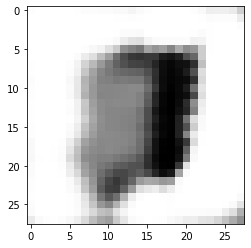

In [32]:
# example of generating an image for a specific point in the latent space
from tensorflow.keras.models import load_model
from numpy import asarray
from matplotlib import pyplot

# load model
model = load_model("generator_model_004.h5")
# all 0s
vector = asarray([[0.0 for _ in range(100)]])
# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap="gray_r")
pyplot.show()